In [1]:
import sklearn
import keras
import numpy as np
from random import randrange
import time

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

# Что такое искуственные нейронные сети и зачем они нужны? 

### Рассмотрим логистическую регрессию

Логистическая регрессия задаётся следующим соотношением: 

$$y = \sigma(x w + b)$$

Где $\sigma = \frac{1}{1 + e^{-x}}$, известная как [сигмоид](https://en.wikipedia.org/wiki/Sigmoid_function). 

Какими свойствами обладает эта модель?

Представим данные следующего вида:

In [4]:
a = np.random.normal(0, 1, size = 1000)
x = (1 + np.random.normal(0, 1, size = 1000)) * np.cos(a)
y = (1 + np.random.normal(0, 1, size = 1000))* np.sin(a)

x2 = (10 + np.random.normal(0, 0.7, size = 1000)) * np.cos(a)
y2 = (10 + np.random.normal(0, 0.7, size = 1000))* np.sin(a)

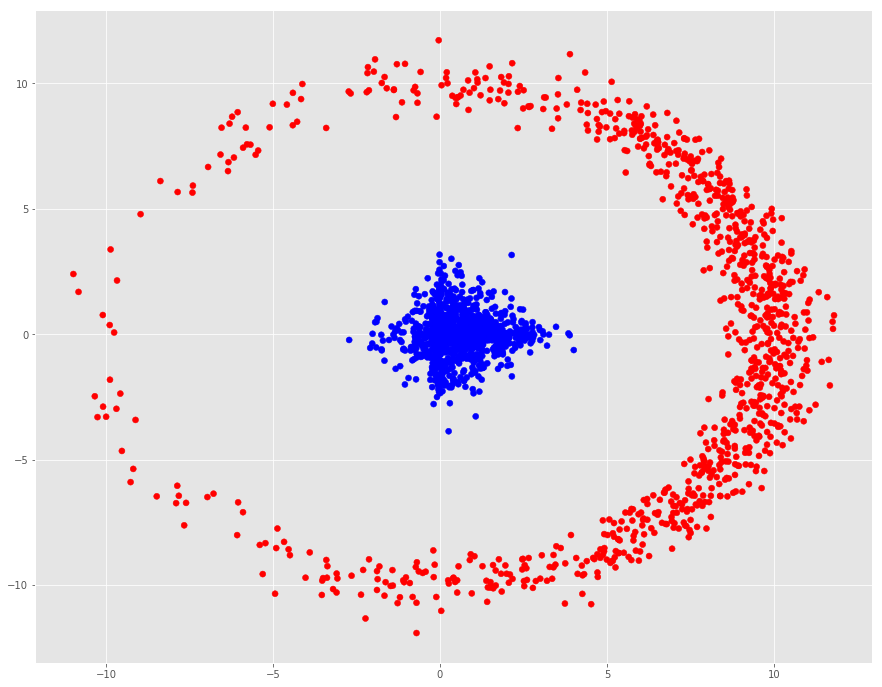

In [5]:
plt.scatter(np.concatenate([x, x2]),np.concatenate([y, y2]), c=  ['b'] * 1000 + ['r'] * 1000)

$$y = \sigma(x w + b)$$

Где $\sigma = \frac{1}{1 + e^{-x}}$, известная как [сигмоид](https://en.wikipedia.org/wiki/Sigmoid_function). 

Какое преобразование над данным надо сделать, чтоб решить задачу классификации с помощью линейной модели?

## Но что делать если мы столкнёмся с более сложными данными?

In [26]:
theta = np.linspace(-1,1,500);
x = np.exp(theta) * np.sin(100*theta);
y = np.exp(theta) * np.cos(100*theta);

In [27]:
np.sin(100*theta)[:20]

array([ 0.50636564,  0.80267477,  0.97175761,  0.98681403,  0.84545754,
        0.57009355,  0.20436808, -0.19375033, -0.56115875, -0.83962187,
       -0.98500247, -0.97425729, -0.8090895 , -0.51567865, -0.14053123,
        0.2568908 ,  0.61359489,  0.87304239,  0.99411013,  0.9576085 ])

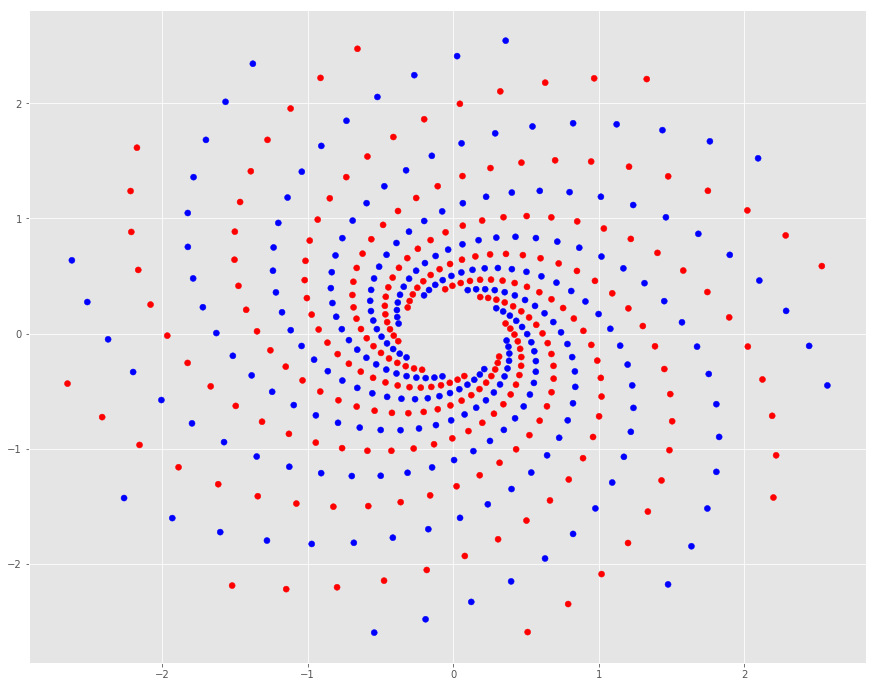

In [30]:
plt.scatter(x,y, c = ['r', 'b'])

Получится ли у нас этот трюк в данном случае?

### Рассмотрим обобщение линейной модели

Опишем в общем виде модель линейной регрессии:
$$f(x) = x'w^T = \phi_i(\langle x',w\rangle)$$

где
* $x = (x_1, x_2, \dots, x_n) \in \Omega$
* $x' = 1 \cup x$, $x'$ -- это вектор-строка $x$, первым (с индексом $0$) элементом которой назначена константа $1$. В дальнейшем будем подразумевать под $x$ вектор данной конструкции. Иногда эта конструкция называется $\textbf{bias trick}$.
* $w = (w_0, w_1, \dots, w_n)$
* $\phi_i$ - базисная функция


Искусственные нейронные сети прямого распространения (feed-forward artificial neural networks):.
	

1. В качестве базисных функций $\phi_i(x)$ возьмём эту же модель.
2. Поступим так несколько раз
3. Верхним индексом обозначаем уровень вложенности (самый "глубокий" $0$)
4. Совокупность элементов имеющих один верхний индекс принято называть "слоем"

Например, так будет выглядеть формула, описывающая простейшую полносвязную сеть с одним скрытым слоем (размерности $3$), решающую задачу бинарной классификации для $x \in R^3$:
	

$$ f(x) = \sigma(w^2_1\sigma(w^1_{11} x_1 + w^1_{12} x_2 + w^1_{13} x_3) + \dots + w^2_3\sigma(w^1_{31} x_1 + w^1_{32} x_2 + w^1_{33} x_3))$$

	
Или в матричном виде. Обратите внимание, что для удобства записи номер слоя теперь обозначен в нижнем индексе:
	

$$ f(x) = \sigma(W_2^T\sigma(W_1^Tx))$$	

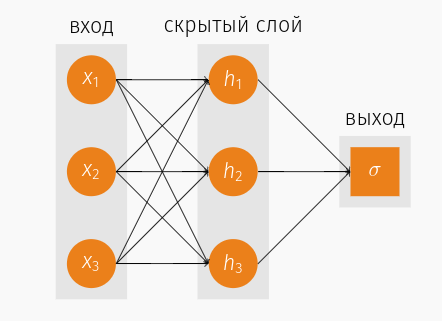

Где $h_i = \sigma(w^1_{i1} x_1 + w^1_{i2} x_2 + w^1_{i3} x_3)$

## Градиентный спуск


Ищем локальный экстремум, идем вдоль градиента

$$ W_{i+1} = W_i - \lambda \nabla L(W_i, X, y) $$

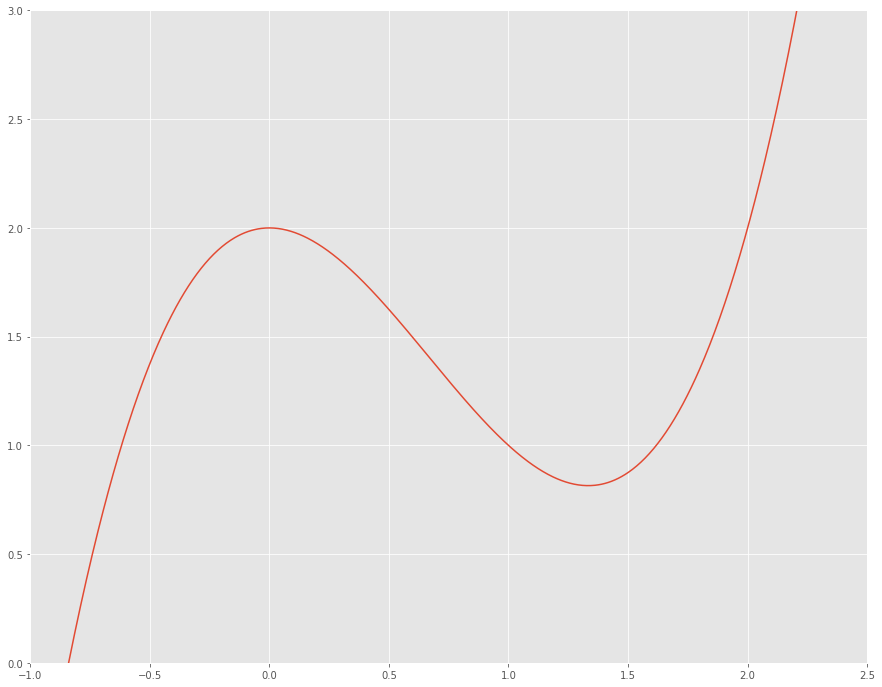

In [9]:
f = lambda x: x ** 3 - 2*x ** 2 + 2
df = lambda x: 3 * x ** 2 - 4 * x # производная
x = np.linspace(-1, 2.5, 1000)
plt.plot(x, f(x))
plt.xlim([-1, 2.5])
plt.ylim([0, 3])
plt.show()

И определим функцию, которая будет оптимизировать функцию $f(x)$ градиентным спуском с заданным постоянным шагом (он же learning rate, темп обучения).

In [10]:
def optimize_and_plot_steps(learning_rate, x_new=2, compute_learning_rate=None):
    x_old = 0
    # x_new — точка старта
    eps = 0.0001
    x_list, y_list = [x_new], [f(x_new)] # инициализируем список координат и значений функций при итерации
    
    # спускаемся, пока разница между координатами не достигла требуемой точности
    i = 0
    while abs(x_new - x_old) > eps: 
        x_old = x_new
        # считаем направление спуска
        direction = -df(x_old)
        # обновляем значение темпа обучения, если нам задана функция для этого
        if compute_learning_rate is not None:
            learning_rate = compute_learning_rate(i, learning_rate)
        # делаем шаг
        x_new = x_old + learning_rate * direction
        # запоминаем очередной шаг минимизации
        x_list.append(x_new)
        y_list.append(f(x_new))
        i += 1
        
    print("Found local min:", x_new)
    print("Steps number:", len(x_list))
    
    plt.figure(figsize=[10,3])
    
    plt.subplot(1,2,1)
    plt.scatter(x_list, y_list, c="r")
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, f(x), c="b")
    plt.xlim([-1,2.5])
    plt.ylim([0,3])
    plt.title("Descent trajectory")

    plt.subplot(1,2,2)
    plt.scatter(x_list,y_list,c="r")
    plt.plot(x_list,y_list,c="r")
    plt.plot(x,f(x), c="b")
    plt.xlim([1.2,2.1])
    plt.ylim([0,3])
    plt.title("Descent trajectory (zoomed in)")
    plt.show()

Попробуем оптимизацию с шагом 0.1

Found local min: 1.333243030069994
Steps number: 18


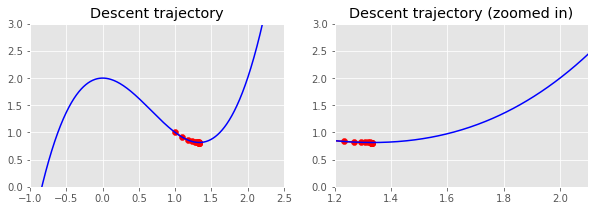

In [11]:
optimize_and_plot_steps(0.1, x_new=1)

Found local min: 1.3333020223878838
Steps number: 15


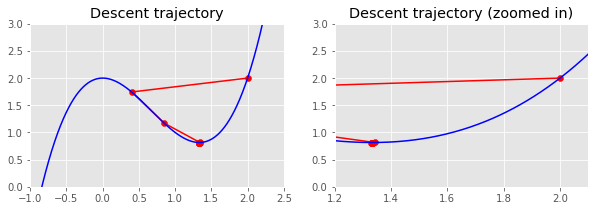

In [12]:
optimize_and_plot_steps(0.4)

Found local min: 0.0
Steps number: 3


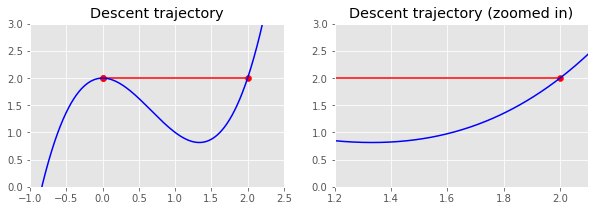

In [13]:
optimize_and_plot_steps(0.5)

Found local min: 1.3333812706364907
Steps number: 188


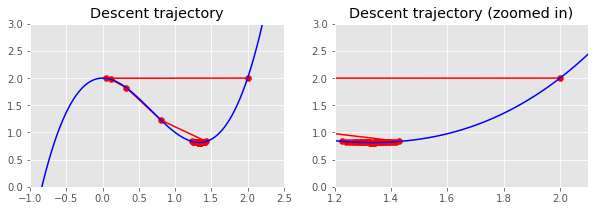

In [14]:
optimize_and_plot_steps(0.49)

In [15]:
optimize_and_plot_steps(0.51)

OverflowError: (34, 'Numerical result out of range')

Found local min: 1.3337297312792562
Steps number: 32


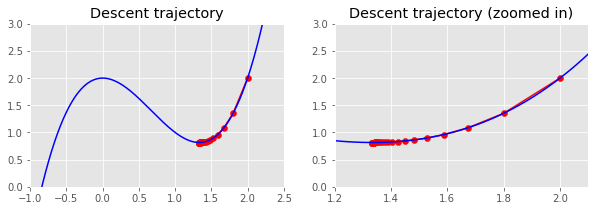

In [16]:
optimize_and_plot_steps(0.05)

Found local min: 1.3356881625009205
Steps number: 129


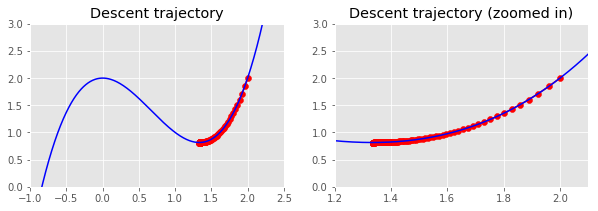

In [17]:
optimize_and_plot_steps(0.01)

In [18]:
def compute_learning_rate(i, prev_lr):
    return prev_lr * 0.9

Found local min: 1.333329734271068
Steps number: 8


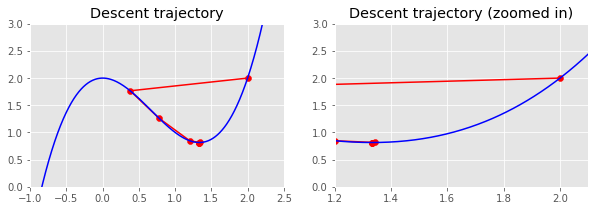

In [19]:
optimize_and_plot_steps(0.45, compute_learning_rate=compute_learning_rate)

Found local min: 1.333371136575378
Steps number: 41


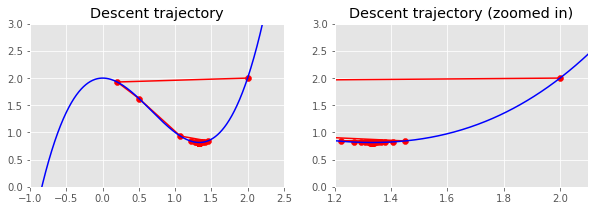

In [20]:
optimize_and_plot_steps(0.45)

### В нейронных сетях есть проблемы препятствующие использованию градиентного спуска

1. Функция невыпуклая

    * Локальные минимумы
    * Седловые точки
2. Миллионы параметров, как следствие низкая скорость обучения и большие затраты по памяти

Решением первых двух проблем является стохастический градиентный спуск

Производят корректировку коэффициентов сети с использованием градиента, который аппроксимируются градиентом функции потерь, вычисленной только на случайном подмножестве обучающей выборки (mini batch).

$$ L(W) = \frac{1}{N} \sum_i^N L_i(W, x_i,y_i)  $$ 
	    
	    
$$ \nabla_W L(W) = \frac{1}{N} \sum_i^N \nabla_W L_i(W, x_i,y_i)  $$

Существует несколько модификаций SGD

* Momentum (импульсный метод)
* RmsProp
* Adam

В дальнейшем мы будем использовать Adam

**Вычислительным графом** (computational graph) называется направленный ациклический граф  в вершинах которого находятся операции из которых состоит исходная функция. Направление в графе отражает зависимость значений одних вершин от других. 

Вычислительные графы позволяют:
* повторно использовать промежуточные результаты
* транслировать описанные функции в реализации на разных языках

*Вычислительные графы используются в большинстве современных библиотек для deep learning. *

### Пример

Например возьмём функцию $y = (a + 2b)(2b + c)$
	
Она состоит из четырёх операций, следовательно в графе будет четыре вершины (и три входа). Выпишем их:

* $g = 2 \cdot b$
* $e = a + g$ 
* $f = g + c$ 
* $y = e \cdot f$ 

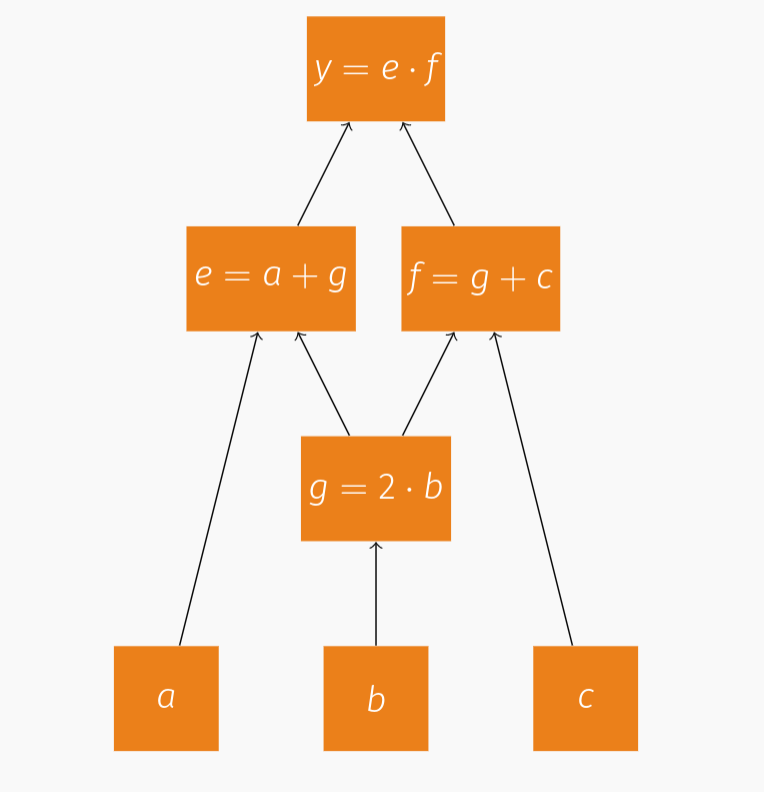

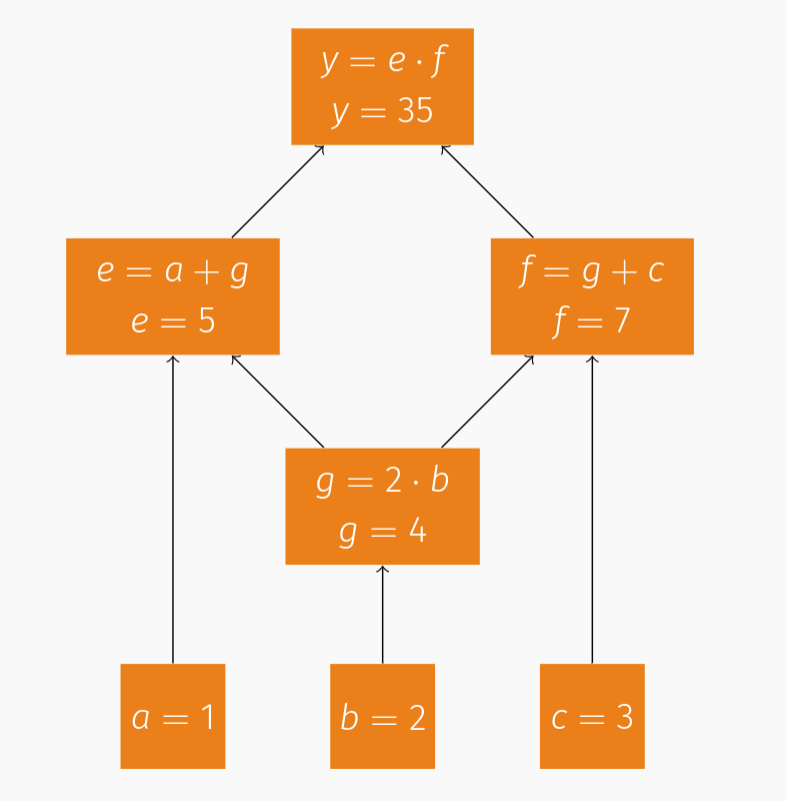

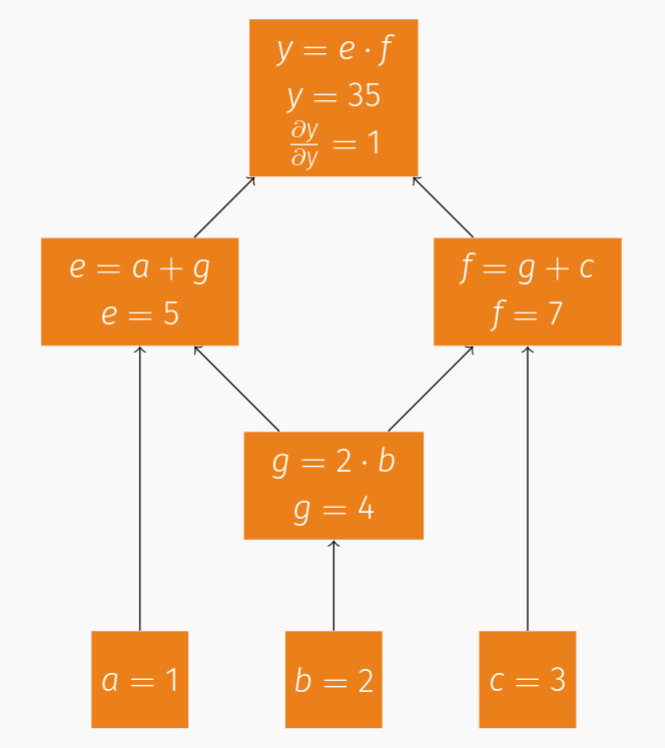

Теперь рассчитаем градиент

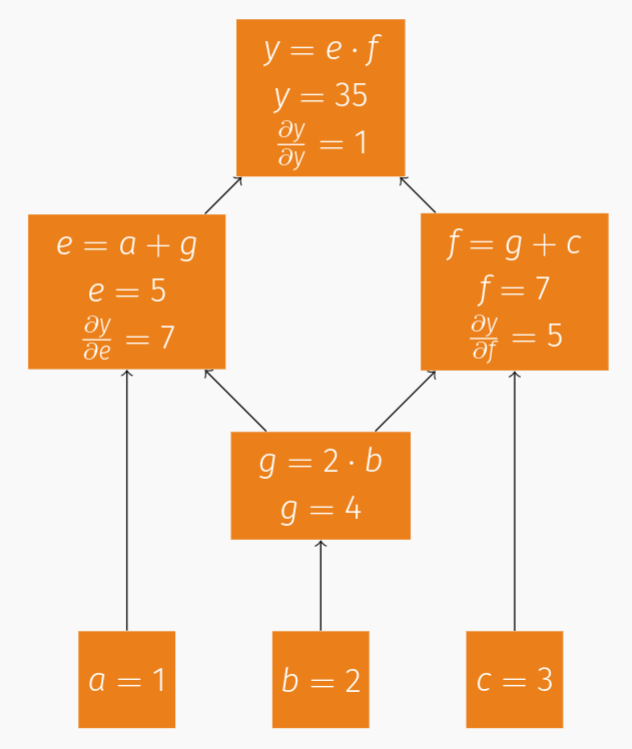

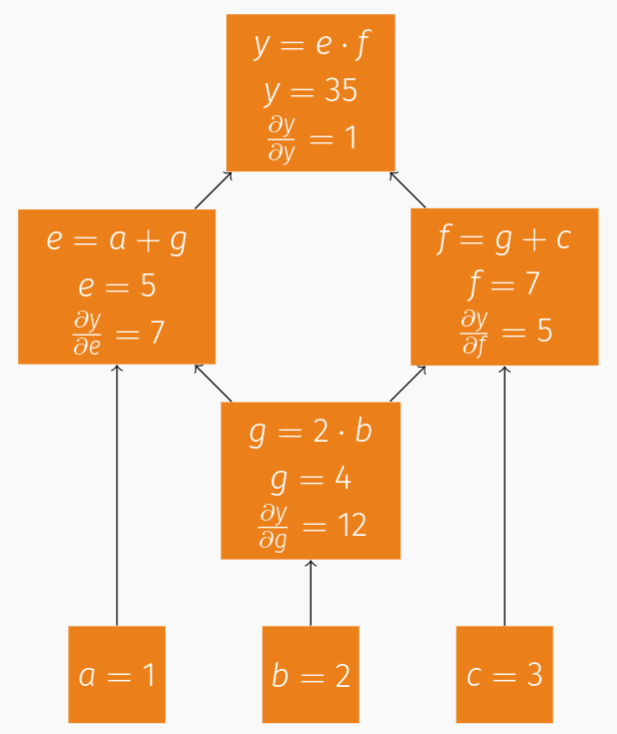

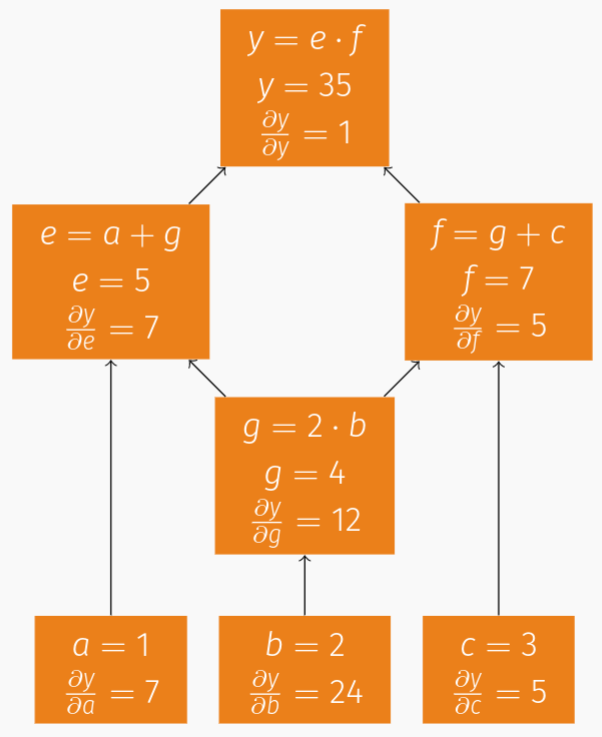

Таким образом мы смогли сразу получить *все* необходимые частные производные. 

Данный подход называется алгоритмом **обратного распространения ошибки (error backpropagation)**.  

* Вычислим градиент функции $y = \sigma  (\sigma(a + b) + \sigma(b * c))$ при помощи метода обратного распространения ошибки
* Примем $a = 9, b = 1, c = 100$ 

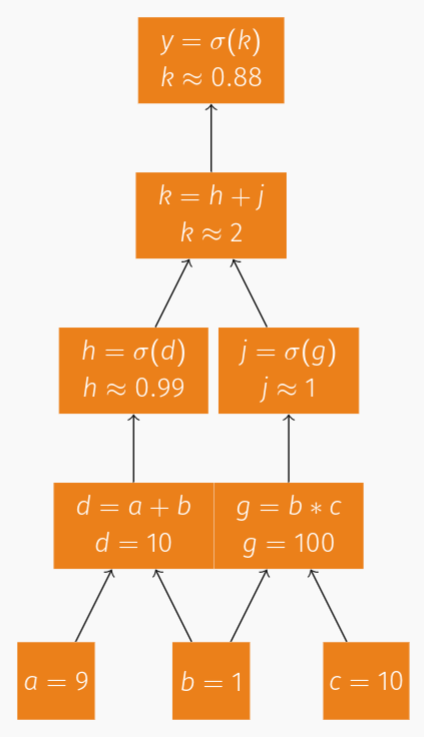

Найдём производную $\sigma(x)$ по $x$:
	
$$ \sigma(x)' = \frac{1}{1 + e^{-x}}' = \frac{0 (1 + e^{-x}) + 1(0 + e^{-x})}{(1 + e^{-x})^2} =  \frac{e^{-x}}{(1 + e^{-x})^2} $$
	
	Или
	
$$ \sigma(x)' = \sigma(x) (1 - \sigma(x)) $$

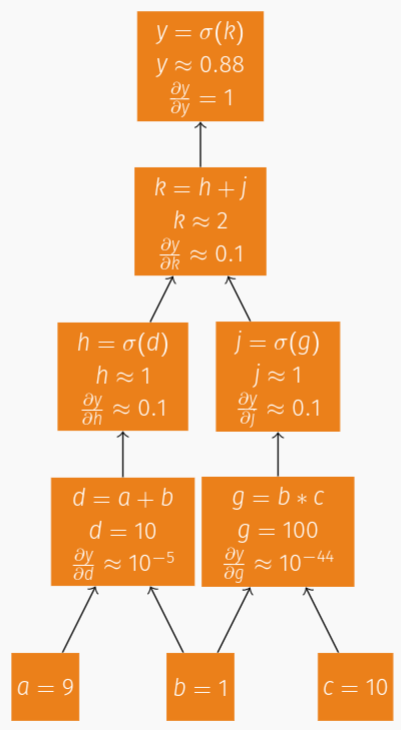

Дальше можно не считать, очевидно, что:
$$ \nabla y(a,b,c) \approx (0,0,0)$$

Данная проблема называется проблемой $\textbf{исчезающего градиента}$ (vanishing gradient problem). 
	
В рассмотренном примере использовалась функция $\sigma(x)$, максимальное значение, которое может принять её производная равно $0.25$. 
	
В глубокой нейронной сети, использующей сигмоид в качестве функции активации между слоями, градиент с большой вероятностью будет исчезать.
	
Важно понимать как работает алгоритм обратного распространения и как ведут себя производные функций активации, которые вы используете! 